#Machine Learning Project - Assignmnet 10
##Optimal Selection of the hyper-parameters associated with the classification on MNIST
###CAUCSE senior 20151145 Kim Jekyun

##Computing Area

###0. Preset

In [121]:
## Import required libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
%matplotlib inline

###1. Data

In [122]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

In [123]:
data_path = './MNIST'

testing_set = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
training_set = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)

print("the number of your training data (must be 10,000) = ", training_set.__len__())
print("the number of your testing data (must be 60,000) = ", testing_set.__len__())

the number of your training data (must be 10,000) =  10000
the number of your testing data (must be 60,000) =  60000


###2. Model

In [124]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.ReLU(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=10*10, out_features=10),
            nn.LogSoftmax(dim=1),
        ) 
        
        
    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out

In [129]:
# Definition of hyper parameters
learning_rate_value = 0.03
batch_size = 64
epochs = 100

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

###3. Loss function

In [130]:
criterion = nn.NLLLoss()

###4. Optimization

In [131]:
# Dataloader & Optimizer
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(testing_set, batch_size=batch_size, shuffle=False)

classifier = classification().to(device)
optimizer = optim.Adadelta(classifier.parameters(), lr=learning_rate_value)

In [ ]:
# Training - Gradient Descent
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    train_loss_tmp = 0
    train_acc_tmp = 0
    length = 0

    classifier.train()
    for data, target in training_loader:
        data, target = data.to(device), target.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward
        output = classifier(data)
        loss = criterion(output, target)
        # Backword
        loss.backward()
        # Loss
        train_loss_tmp += loss
        length += batch_size
        # Update
        optimizer.step()
        # Accuracy
        result = output.argmax(dim=1, keepdim=True)
        accuracy = result.eq(target.view_as(result)).sum()
        train_acc_tmp += accuracy
    
    train_loss.append(train_loss_tmp / length)
    train_acc.append(train_acc_tmp / length)
    if epoch%10 == 0:
        print('Training - Epoch : {}, Loss : {}, Accuracy : {}'.format(epoch, train_loss[-1], train_acc[-1]))

    test_loss_tmp = 0
    test_acc_tmp = 0
    length = 0
    
    classifier.eval()
    with torch.no_grad():
        for data, target in testing_loader:
            data, target = data.to(device), target.to(device)
            # Forward
            output = classifier(data)
            loss = criterion(output, target)
            # Loss
            test_loss_tmp += loss
            length += batch_size
            # Accuracy
            result = output.argmax(dim=1, keepdim=True)
            accuracy = result.eq(target.view_as(result)).sum()
            test_acc_tmp += accuracy
    
    test_loss.append(test_loss_tmp / length)
    test_acc.append(test_acc_tmp / length)
    if epoch%25 == 0:
        print('Testing - Epoch : {}, Loss : {}, Accuracy : {}'.format(epoch, test_loss[-1], test_acc[-1]))

Training - Epoch : 0, Loss : 0.024694962427020073, Accuracy : 0.621715784072876
Testing - Epoch : 0, Loss : 0.013762451708316803, Accuracy : 0.8024886846542358
Training - Epoch : 10, Loss : 0.0035494498442858458, Accuracy : 0.928045392036438
Training - Epoch : 20, Loss : 0.00216635107062757, Accuracy : 0.9549164175987244
Testing - Epoch : 25, Loss : 0.0031162535306066275, Accuracy : 0.9395822286605835
Training - Epoch : 30, Loss : 0.0013966825790703297, Accuracy : 0.9694466590881348
Training - Epoch : 40, Loss : 0.0009583575883880258, Accuracy : 0.9788017868995667
Training - Epoch : 50, Loss : 0.0006493327673524618, Accuracy : 0.9850716590881348
Testing - Epoch : 50, Loss : 0.002683906117454171, Accuracy : 0.9492437839508057
Training - Epoch : 60, Loss : 0.0004378060402814299, Accuracy : 0.9890525341033936
Training - Epoch : 70, Loss : 0.0002931766794063151, Accuracy : 0.9915406107902527
Testing - Epoch : 75, Loss : 0.0026939676608890295, Accuracy : 0.9529750943183899
Training - Epoch 

In [115]:
train_loss_tot = train_loss[-1]
test_loss_tot = test_loss[-1]
train_acc_tot = train_acc[-1]
test_acc_tot = test_acc[-1]

In [116]:
ind = ['training', 'testing']
con_loss = {'loss':ind, '':[train_loss_tot.item(), test_loss_tot.item()]}
con_acc = {'accuracy':ind, '':[train_acc_tot.item(), test_acc_tot.item()]}

tot_loss = pd.DataFrame(con_loss).set_index('loss')
tot_acc = pd.DataFrame(con_acc).set_index('accuracy')

---
##Result Area

###1. Plot the training and testing losses over epochs

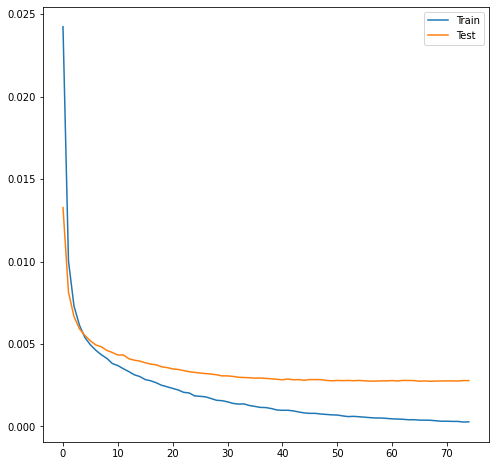

In [117]:
plt.figure(figsize=(8,8))
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['Train', 'Test'])
plt.show()

###  
###  
###  
  

###  
###  
###  
  

###  
###  
###  
  

###  
###  
###  
  

###  
###  
###  
  

###  
###  
###  
  

###  
###  
###  
  

###2. Plot the training and testing accuracies over epochs

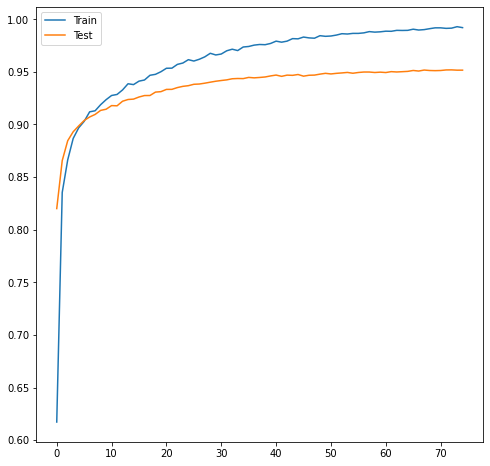

In [118]:
plt.figure(figsize=(8,8))
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(['Train', 'Test'])
plt.show()

###3. Print the final training and testing losses at convergence

In [119]:
tot_loss

,
loss,
training,0.000282
testing,0.002780


###4. Print the final training and testing accuracies at convergence

In [120]:
tot_acc

,
acc,
training,0.992038
testing,0.951626
